![ImageFormation](https://drive.google.com/uc?id=1TWC2QgVky_x-tBmr-apJE4VUxApl1W4q)

#**Hands-on Sesión 2.4: Convolución y Filtrado de Imágenes**

## **Contenido**

[**1. Convolution**](#tema1)

[**2. Gaussian Filtering**](#tema2)

[**3. Adding noise**](#tema3)

[**4. Blur**](#tema4)

[**5. Filtrado Inverso**](#tema5)


## <font color='#4C5FDA'>**Convolution**</font> <a name="tema1">

In [9]:
import numpy as np

def zero_pad(X, pad):
    X_pad = np.pad(X, pad, 'constant', constant_values=0)
    return X_pad

def conv_step(x, W):
        return np.sum(np.multiply(x, W))

def conv(s, k):
    diff = abs(len(s) - len(k) - 1)
    slide = len(k)
    # flip kernel
    k = k [::-1]
    Z = np.zeros(shape=len(s)-diff)
    for i in range(Z.shape[0]):
        Z[i] = conv_step(s[i:i+slide], k)
    return Z

s = [1,2,3,4]
g = [0.5,0,-0.5]
print(np.convolve(s, g, 'same'))  # [ 1.   1.   1.  -1.5]
print(conv(zero_pad(s,1),g))  # [ 1.   1.   1.  -1.5]

[ 1.   1.   1.  -1.5]
[ 1.   1.   1.  -1.5]


<font color="EB9A54">**Con Scikit-learn:**</font>

https://pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/

In [10]:
# import the necessary packages
from skimage.exposure import rescale_intensity
import numpy as np
import argparse
import cv2

In [11]:
!pip install -U scikit-image

In [28]:
image.shape[:2]

(256, 256)

In [12]:
def convolve(image, kernel):
	# grab the spatial dimensions of the image, along with
	# the spatial dimensions of the kernel
	(iH, iW) = image.shape[:2]
	(kH, kW) = kernel.shape[:2]
	# allocate memory for the output image, taking care to
	# "pad" the borders of the input image so the spatial
	# size (i.e., width and height) are not reduced
	pad = (kW - 1) // 2
	image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
		cv2.BORDER_REPLICATE)
	output = np.zeros((iH, iW), dtype="float32")
  # loop over the input image, "sliding" the kernel across
	# each (x, y)-coordinate from left-to-right and top to
	# bottom
	for y in np.arange(pad, iH + pad):
		for x in np.arange(pad, iW + pad):
			# extract the ROI of the image by extracting the
			# *center* region of the current (x, y)-coordinates
			# dimensions
			roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
			# perform the actual convolution by taking the
			# element-wise multiplicate between the ROI and
			# the kernel, then summing the matrix
			k = (roi * kernel).sum()
			# store the convolved value in the output (x,y)-
			# coordinate of the output image
			output[y - pad, x - pad] = k

  # rescale the output image to be in the range [0, 255]
	output = rescale_intensity(output, in_range=(0, 255))
	output = (output * 255).astype("uint8")
	# return the output image
	return output

In [13]:
# construct average blurring kernels used to smooth an image
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))

# construct a sharpening filter
sharpen = np.array((
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]), dtype="int")

# construct the Laplacian kernel used to detect edge-like
# regions of an image
laplacian = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

# construct the Sobel x-axis kernel
sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")

# construct the Sobel y-axis kernel
sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")

In [14]:
# construct the kernel bank, a list of kernels we're going
# to apply using both our custom `convole` function and
# OpenCV's `filter2D` function
kernelBank = (
	("small_blur", smallBlur),
	("large_blur", largeBlur),
	("sharpen", sharpen),
	("laplacian", laplacian),
	("sobel_x", sobelX),
	("sobel_y", sobelY)
)

[INFO] applying small_blur kernel


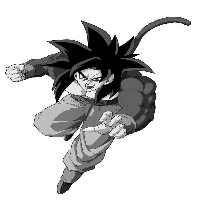

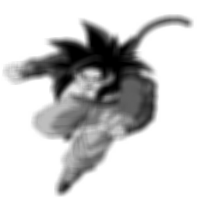

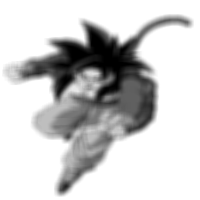

[INFO] applying large_blur kernel


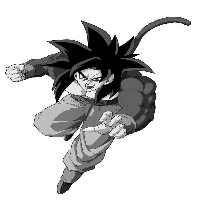

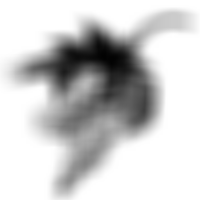

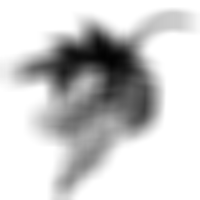

[INFO] applying sharpen kernel


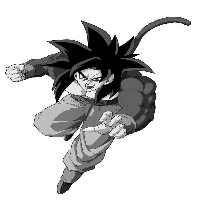

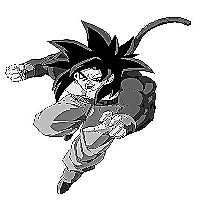

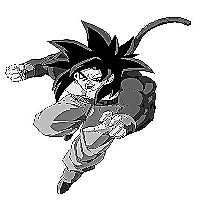

[INFO] applying laplacian kernel


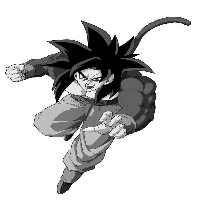

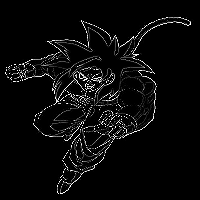

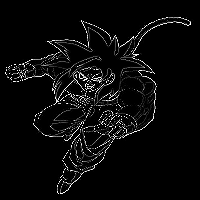

[INFO] applying sobel_x kernel


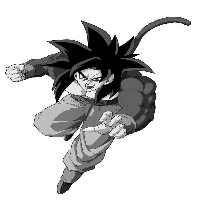

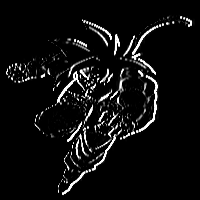

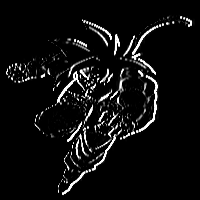

[INFO] applying sobel_y kernel


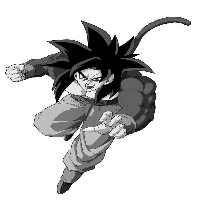

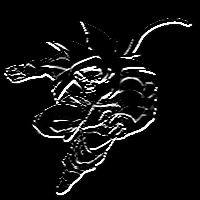

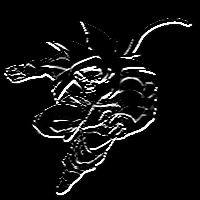

In [29]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import urllib.request

# load the input image and convert it to grayscale

resp = urllib.request.urlopen("https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/main/Sesiones/Sesion2/Imagenes/goku1.jpeg")
image = np.asarray(bytearray(resp.read()), dtype="uint8")

# decode the imagen
image = cv2.imdecode(image, cv2.IMREAD_COLOR)


image = cv2.resize(image, (200,200))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# loop over the kernels
for (kernelName, kernel) in kernelBank:
  # apply the kernel to the grayscale image using both
  # our custom `convole` function and OpenCV's `filter2D`
  # function
  print("[INFO] applying {} kernel".format(kernelName))
  convolveOutput = convolve(gray, kernel)
  opencvOutput = cv2.filter2D(gray, -1, kernel)
  # show the output images
  cv2_imshow(gray)
  cv2_imshow(convolveOutput)
  cv2_imshow(opencvOutput)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

## <font color='#4C5FDA'>**Gaussian Filtering**</font> <a name="tema2">

In [16]:
def gaussian_kernel(sample_range, sigma=1):
    """
    creates a gaussian kernel sampled between [-sample_range, sample_range] with a standard deviation of sigma
    """

    ax = np.linspace(-sample_range, sample_range)
    xx, yy = np.meshgrid(ax, ax)

    # 2d gaussian function in our case, but this can be any arbitrary function parametrized by x and y
    kernel = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma **2))
    return kernel / np.sum(kernel)

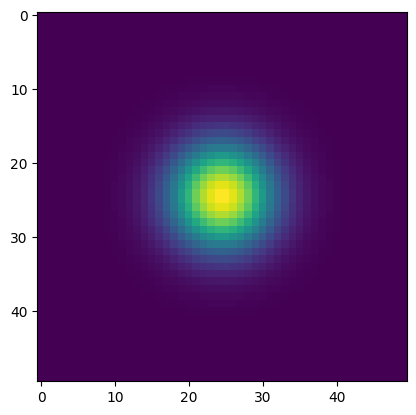

In [17]:
kernel = gaussian_kernel(50, sigma=10)
plt.imshow(kernel)
plt.show()

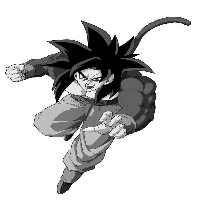

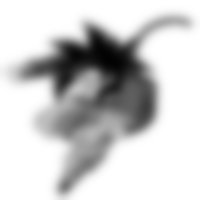

In [18]:
opencvOutput = cv2.filter2D(gray, -1, kernel)
# show the output images
cv2_imshow(gray)
cv2_imshow(opencvOutput)

## <font color='#4C5FDA'> **Adding noise**</font> <a name="tema3">

1. White noise
2. Salt and paper noise
3. Shot noise


In [19]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import fftpack
import scipy.signal
import warnings
warnings.filterwarnings('ignore')

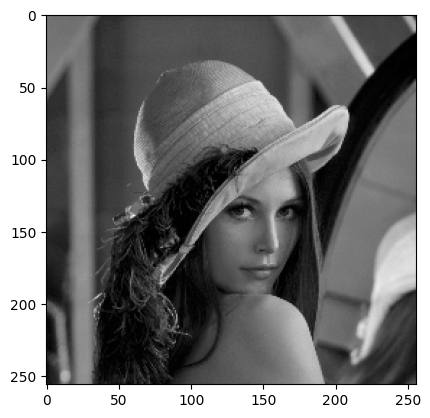

In [20]:
WHITE_LEVEL = 255
SIZE = 256


resp = urllib.request.urlopen("https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/main/Sesiones/Sesion2/Imagenes/Lena.jpg")

# Convertir la imagen a un array de bytes
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)
image = image / WHITE_LEVEL



image = cv2.resize(image, (SIZE, SIZE))

plt.imshow(image, cmap='gray')
plt.show()

<font color="EB9A54"> **White noise** </font>

El ruido blanco es un ruido aditivo Gaussiano que es i.i.d. de media cero. Es el modelo más común para generar imágenes de ruido. Es difícil lidiar con este tipo de ruido incluso en el dominio de la frecuencia, ya que tiene la misma intensidad en todas las frecuencias. ​

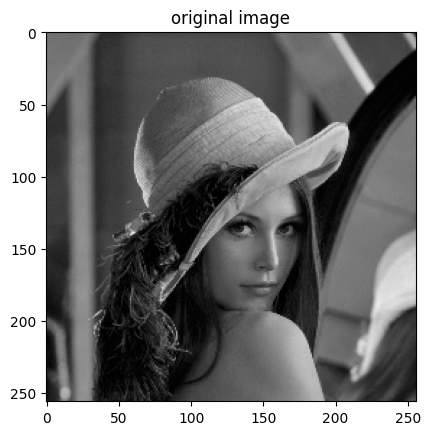

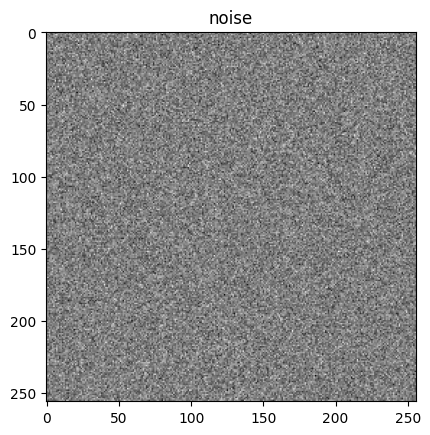

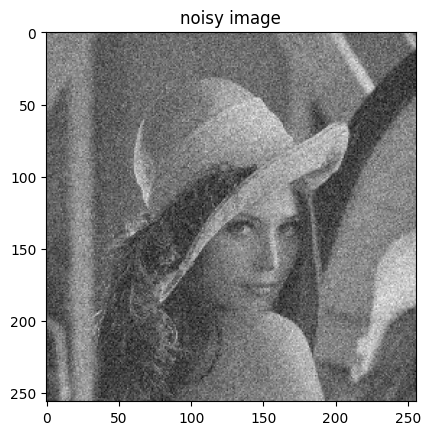

In [21]:
NOISE_STD = 0.1

noise = np.random.normal(scale=NOISE_STD, size=image.shape)
noisy_image = image + noise

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

plt.imshow(noise, cmap='gray')
plt.title('noise')
plt.show()

plt.imshow(noisy_image, cmap='gray')
plt.title('noisy image')
plt.show()

Analizando el ruido en el dominio de la frecuencia

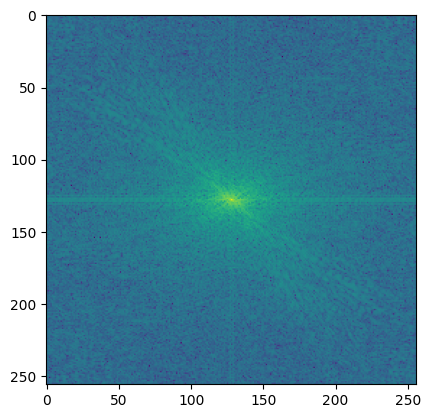

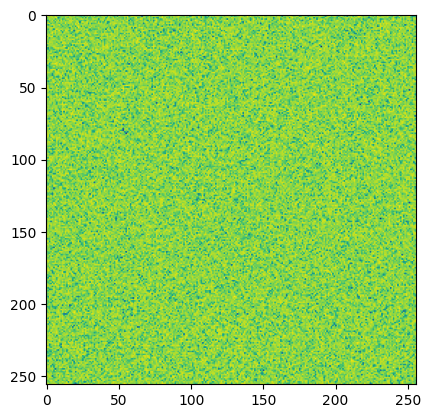

In [22]:
from scipy.fftpack import fft2, fftshift

fourier_lena = fftshift(fft2(image))
plt.imshow(np.log(np.abs(fourier_lena)))
plt.show()

fourier_noise = fftshift(fft2(noise))
plt.imshow(np.log(np.abs(noise)))
plt.show()

<font color="EB9A54"> **Salt & pepper noise:** </font>

El ruido de sal y pimienta se presenta como píxeles blancos y negros que aparecen escasamente. Puede ocurrir debido al uso de instrumentos defectuosos.

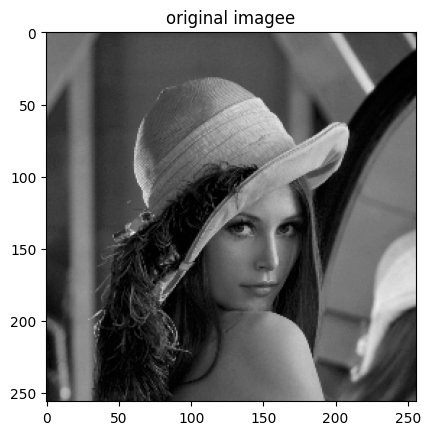

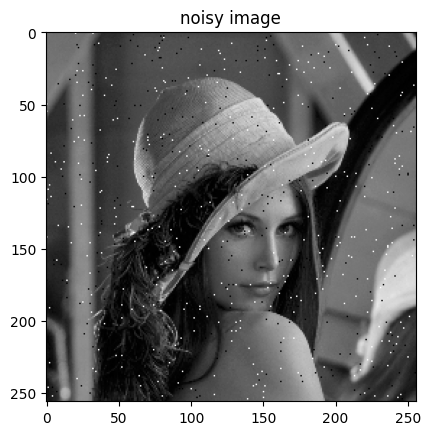

In [23]:
AMOUNT = 0.01   # proportion of pixels are corrupted
SALT_VS_PEPPER = 0.5  # probability of being blank or saturated

noisy_image = image.copy()
number_faulty_pixels = np.ceil(AMOUNT * image.size).astype(int)
indices = np.random.randint(0, high=SIZE, size=(2, number_faulty_pixels))
values = np.random.binomial(1, SALT_VS_PEPPER, size=number_faulty_pixels)
noisy_image[tuple(np.split(indices, 2))] = values

plt.imshow(image, cmap='gray')
plt.title('original imagee')
plt.show()

plt.imshow(noisy_image, cmap='gray')
plt.title('noisy image')
plt.show()

<font color="EB9A54"> **Shot Noise** </font>

El ruido de disparo es cualquier tipo discreto de ruido que puede modelarse como un proceso de Poisson. Ocurre en el conteo de fotones en dispositivos ópticos, debido a la naturaleza como partícula de la luz. Por tanto, este tipo de ruido se nota especialmente en condiciones de poca luz, o cuando el tiempo de exposición es corto.

No debe confundirse con el ruido oscuro, que es un ruido de Poisson aditivo.

Note que los píxeles brillantes serán más ruidosos que los oscuros, porque $E[X] = Var[X] = \lambda$.

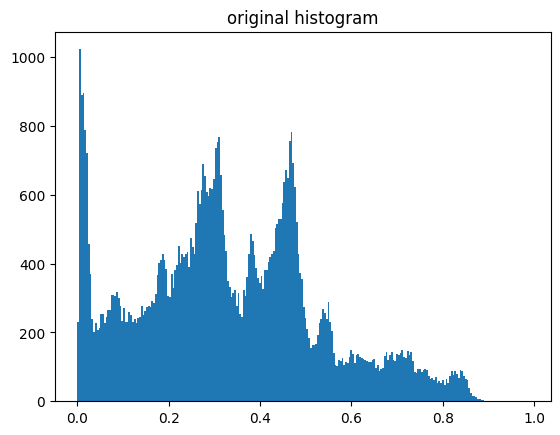

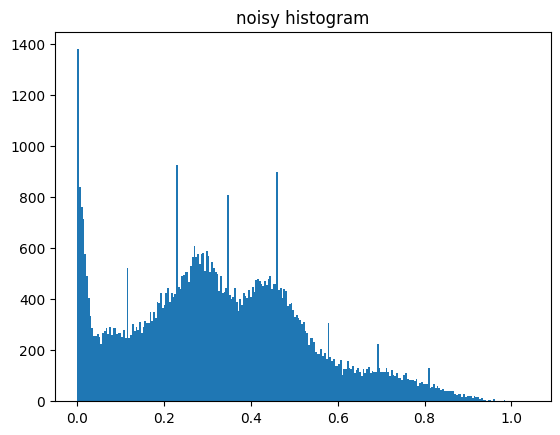

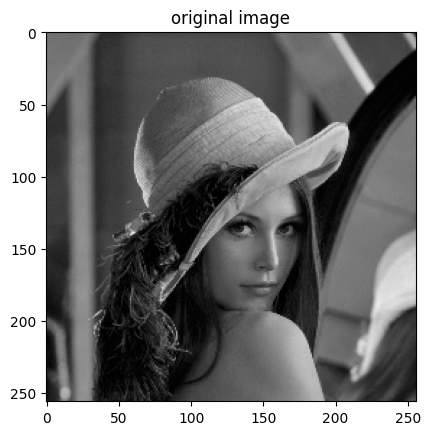

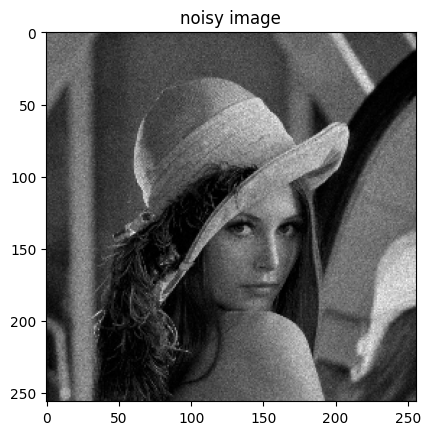

In [24]:
NUM_BINS = 256

lam = image * WHITE_LEVEL
noisy_image = np.random.poisson(lam=lam) / WHITE_LEVEL

plt.hist(image.ravel(), bins=NUM_BINS)
plt.title('original histogram')
plt.show()

plt.hist(noisy_image.ravel(), bins=NUM_BINS)
plt.title('noisy histogram')
plt.show()

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

plt.imshow(noisy_image, cmap='gray')
plt.title('noisy image')
plt.show()

## <font color='#4C5FDA'> **Blur** </font> <a name="tema4">
1. Focal blur
2. Motion blur

<font color="EB9A54"> **Focal blur** </font>

A la respuesta al impulso de un sistema de imágenes la llamamos PSF (función de dispersión de puntos). Idealmente nos gustaría que el PSF fuera la función indicadora. Sin embargo, en realidad, debido a limitaciones físicas, el enfoque de las lentes de la cámara no es óptimo.

Pruebe la siguiente función aumentando PSF_STD y observe cómo difumina la imagen, provocando que se pierda la información en las frecuencias más altas.

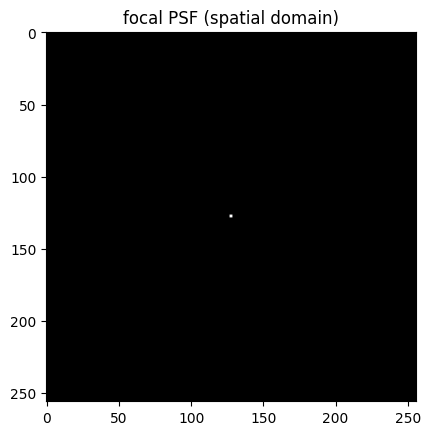

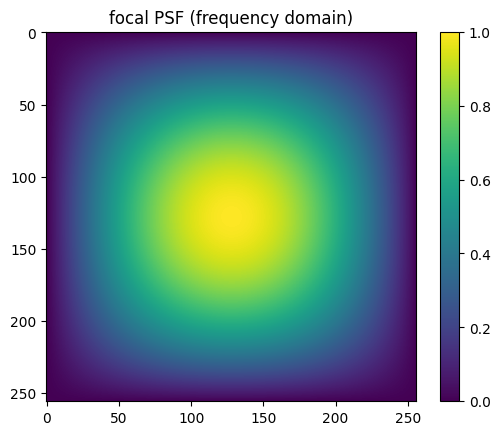

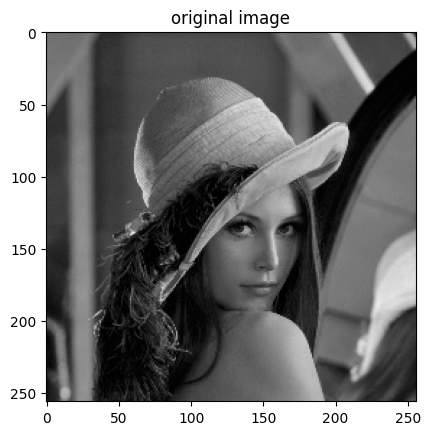

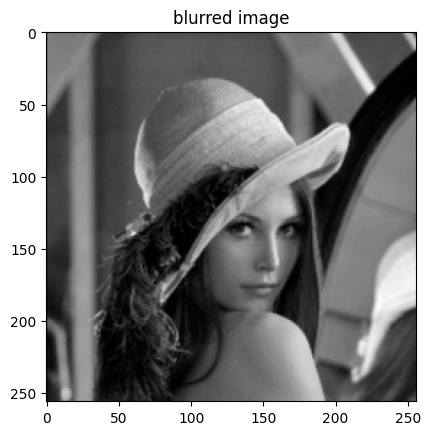

In [25]:
FOCAL_STD = 0.1 # 3  # if focal blur is increased in spatial domain, what happens in the Fourier domain?

def gaussian_kernel(size, std=1):
    edge = size // 2
    ax = np.linspace(-edge, edge, num=size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx ** 2 + yy ** 2) / (2 * std **2))
    return kernel / kernel.sum()

psf = gaussian_kernel(SIZE, std=FOCAL_STD)
plt.imshow(psf, cmap='gray')
plt.title('focal PSF (spatial domain)')
plt.show()

psf_dft = fftpack.fftshift(fftpack.fft2(psf))
plt.title('focal PSF (frequency domain)')
plt.imshow(np.abs(psf_dft))
plt.colorbar()
plt.show()

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

blurred_image = scipy.signal.convolve(image, psf, mode='same')
plt.imshow(blurred_image, cmap='gray')
plt.title('blurred image')
plt.show()

<font color="EB9A54"> **Motion blur** </font>

Si la cámara se mueve cuando se expone la apertura, la PSF cambia, lo que produce un desenfoque de movimiento.
En comparación con el desenfoque focal, podemos ver que la información en algunas de las frecuencias más altas aún se mantiene, dependiendo de la dirección del movimiento.

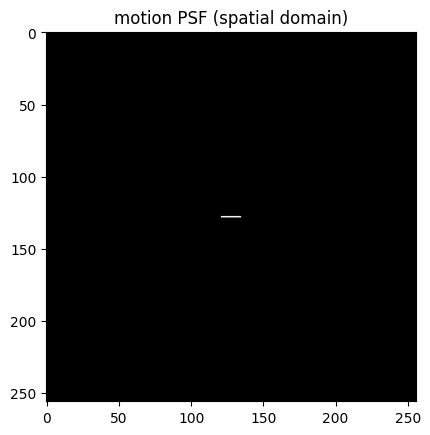

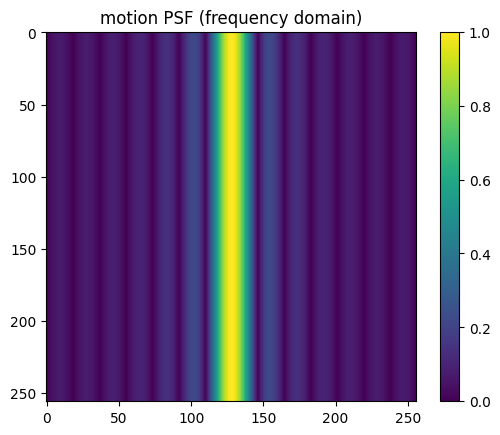

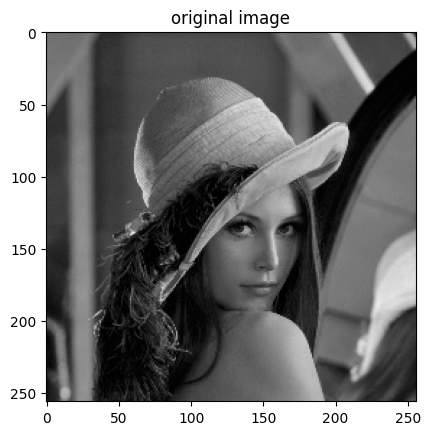

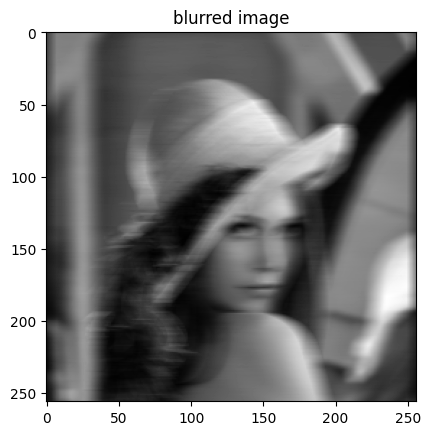

In [26]:
LENGTH = 15

def horizontal_motion_blur(size, length):
    center = size // 2
    shift = length // 2
    kernel = np.zeros((size, size))
    kernel[center:center + 1, center - shift:center + shift] = 1
    return kernel / kernel.sum()

psf = horizontal_motion_blur(SIZE, LENGTH)
plt.imshow(psf, cmap='gray')
plt.title('motion PSF (spatial domain)')
plt.show()

psf_dft = fftpack.fftshift(fftpack.fft2(psf))
plt.title('motion PSF (frequency domain)')
plt.imshow(np.abs(psf_dft))
plt.colorbar()
plt.show()

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

blurred_image = scipy.signal.convolve(image, psf, mode='same')
plt.imshow(blurred_image, cmap='gray')
plt.title('blurred image')
plt.show()

## <font color='#4C5FDA'> **Filtrado inverso** </font> <a name="tema5">

Si tenemos la siguiente ecuación (sin ruido):
$y = h \circledast f $

donde $f$ es la imagen limpia y $y$ es la versión difuminada que se obtiene mediante el desenfoque PSF.


El objetivo del filtrado inverso es recuperar la imagen limpia $f$ conociendo $y$ y la PSF $h$.

Note que en el dominio de la frecuencia, la ecuación inicial se puede representar como:

$Y = HF$

Idealmente, como nos explicaron en algebra lineal, podemos estimar $F$ haciendo:

$\hat{F} = Y/H$

Este método se llama filtrado inverso. Veamos qué tan bien se desempeña en la práctica.

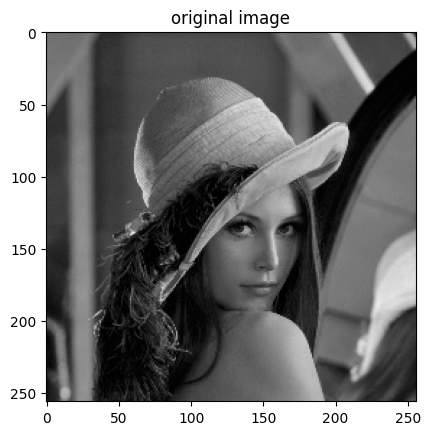

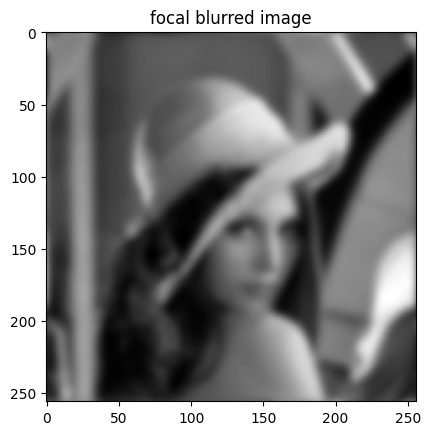

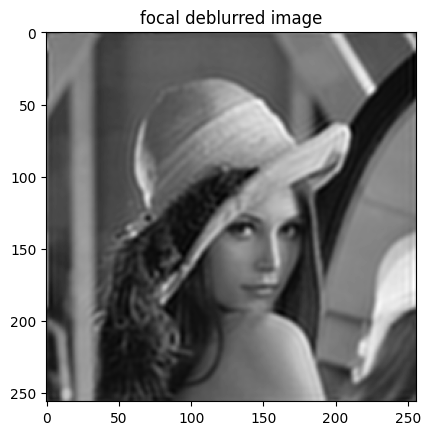

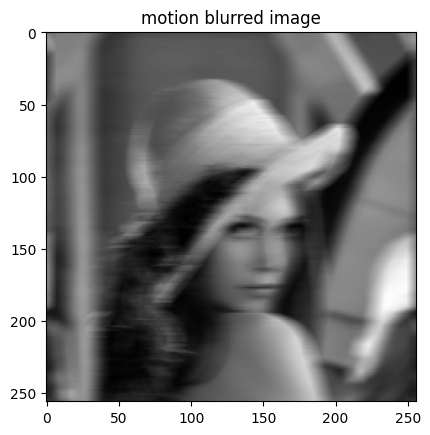

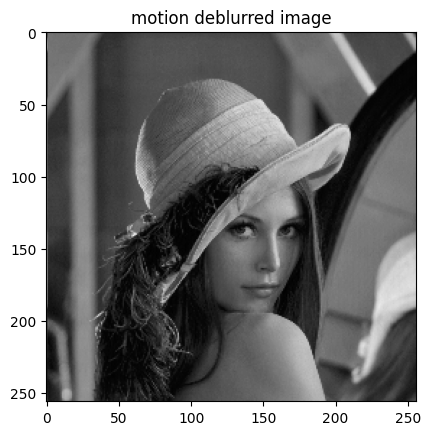

In [27]:
EPSILON = 1e-3
FOCAL_STD = 3
LENGTH = 15

def inverse_filter(image, psf):
    image_dft = fftpack.fft2(image)
    psf_dft = fftpack.fft2(fftpack.ifftshift(psf))
    recovered_dft = image_dft / (psf_dft + EPSILON)
    return np.real(fftpack.ifft2(recovered_dft))

plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

focal_blur_psf = gaussian_kernel(SIZE, std=FOCAL_STD)
focal_blurred_image = scipy.signal.convolve2d(image, focal_blur_psf, mode='same', boundary='wrap')
plt.imshow(focal_blurred_image, cmap='gray')
plt.title('focal blurred image')
plt.show()

focal_deblurred_image = inverse_filter(focal_blurred_image, focal_blur_psf)
plt.imshow(focal_deblurred_image, cmap='gray')
plt.title('focal deblurred image')
plt.show()

motion_blur_psf = horizontal_motion_blur(SIZE, LENGTH)
motion_blurred_image = scipy.signal.convolve2d(image, motion_blur_psf, mode='same', boundary='wrap')
plt.imshow(motion_blurred_image, cmap='gray')
plt.title('motion blurred image')
plt.show()

motion_deblurred_image = inverse_filter(motion_blurred_image, motion_blur_psf)
plt.imshow(motion_deblurred_image, cmap='gray')
plt.title('motion deblurred image')
plt.show()

Dado que el desenfoque focal concentró toda la información en las frecuencias más altas, nuestra imagen desenfocada contiene artefactos de alta frecuencia, que son similares a los artefactos de alias que hemos visto durante el muestreo. Son principalmente visibles cerca de los bordes.

La imagen desenfocada que obtuvimos para el caso de desenfoque de movimiento, por otro lado, se ve genial. Esto se debe a que no toda la información de las altas frecuencias desapareció y el método de filtrado inverso pudo recuperarla.

Preste atención al hecho de que hemos establecido el parámetro border='wrap' para scipy.signal.convolve2d. Intenta cambiarlo. ¿Cómo afecta a las imágenes desenfocadas?

La razón detrás de esto es el hecho de que DFT diagonaliza operadores de convolución circulares (o matrices circulares, como explicamos en el tutorial 2). Esta propiedad es necesaria para que el teorema de convolución y, por tanto, el método de filtrado inverso, siga siendo válido en el caso discreto. Alternativamente, podríamos haber implementado la convolución mediante la multiplicación puntual en el dominio de la frecuencia.